In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import community
import community.community_louvain as community_louvain
import networkx as nx
import random
import collections
import csv
import seaborn as sns

In [2]:
def data_graph(dataset, delimiter):
    
    data = pd.read_csv(dataset, delimiter=delimiter)
    print(data.shape)
    if dataset == 'epinion.txt':
        data.columns = ['From','To','Weight']
    elif dataset == 'wiki.txt':
        data.columns = ['From','To']
        tempWeight = [1 for i in range(103689)]
        data['Weight'] = tempWeight
    elif dataset == 'bitcoin.csv':
        data.columns = ['From','To','Weight','Time']
    print(data.head())
    
    graph = nx.DiGraph()
    # Adding the edges.
    for index,row in data.iterrows():
        graph.add_edges_from([(row[0],row[1])],weight = row[2])
    
    return data, graph

In [3]:
epi_csv, epi_graph = data_graph('epinion.txt',"\t")

(841372, 3)
   From      To  Weight
0     0       1      -1
1     1  128552      -1
2     2       3       1
3     4       5      -1
4     4     155      -1


In [4]:
wiki_csv, wiki_graph = data_graph('wiki.txt',"\t")

(103689, 2)
   From    To  Weight
0    30  1412       1
1    30  3352       1
2    30  5254       1
3    30  5543       1
4    30  7478       1


In [5]:
bitcoin_csv, bitcoin_graph = data_graph('bitcoin.csv',",")

(35592, 4)
   From  To  Weight          Time
0     6   2       4  1.289242e+09
1     6   5       2  1.289242e+09
2     1  15       1  1.289243e+09
3     4   3       7  1.289245e+09
4    13  16       8  1.289254e+09


In [12]:
def recrprocity(data, skip):
    pos = data.loc[data['Weight'] > 0]
    neg = data.loc[data['Weight'] < 0]
    graphP = nx.DiGraph()
    # Adding the edges.
    for index,row in pos.iterrows():
        graphP.add_edges_from([(row[0],row[1])])
    print('+ve reciprocity: ' + str(nx.reciprocity(graphP)))
    if not skip:
        graphN = nx.DiGraph()
        # Adding the edges.
        for index,row in neg.iterrows():
            graphN.add_edges_from([(row[0],row[1])])
        print('-ve reciprocity: ' + str(nx.reciprocity(graphN)))

In [10]:
recrprocity(epi_csv, False)

+ve reciprocity: 0.3470634709412583
-ve reciprocity: 0.03796127884887434


In [13]:
recrprocity(wiki_csv, True)

+ve reciprocity: 0.0564572905515532


In [15]:
recrprocity(bitcoin_csv, False)

+ve reciprocity: 0.8391145524368541
-ve reciprocity: 0.17064271681167556


In [17]:
def stats(data,graph):
    # Number of nodes
    print('Nodes = ' + str(graph.number_of_nodes()))

    # Number of edges
    print('Edges = ' + str(graph.number_of_edges()))

    # Positive and negative edges 

    Stats = pd.DataFrame(graph.out_degree(),columns=['From','Outdegree']).sort_values('From')
    Stats_2 =  pd.DataFrame(graph.in_degree(),columns=['To','Indegree']).sort_values('To')
    b= data.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
    c= data.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')
    Stats = Stats.merge(b,on='From',how='left')
    Stats_2 = Stats_2.merge(c,on='To',how='left')
    Stats['Pos_out'] = (  Stats['Outdegree'] + Stats['Weight']  )/2
    Stats['Neg_out'] = (  Stats['Outdegree'] - Stats['Weight']  )/2
    Stats_2['Pos_in']= (Stats_2['Indegree']  + Stats_2['Weight'])/2
    Stats_2['Neg_in']= (Stats_2['Indegree']  - Stats_2['Weight'])/2
    Stats = pd.merge(Stats,Stats_2,left_on='From', right_on='To').drop('To', axis=1)
    Stats = Stats.drop(['Weight_x','Weight_y'],axis=1)
    Stats.fillna(0,inplace=True)
    print(Stats.head())
    
    print(Stats.describe())
    print(Stats.max(axis=0))
    
    print('Average Clustering = ' + str(nx.average_clustering(graph)))
    print('Transitivity = '+ str(nx.transitivity(graph)))
    print('Density = ' + str(nx.density(graph)))
    
    data['Weight'].plot.hist(bins=2, alpha=1, align='mid')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Count of weight of edges')
    plt.xticks([-1,1])
    plt.show()
    
    return Stats

Nodes = 131828
Edges = 841372
   From  Outdegree  Pos_out  Neg_out  Indegree  Pos_in  Neg_in
0     0          1      0.0      1.0         0     0.0     0.0
1     1          1      0.0      1.0         2     1.0     1.0
2     2          1      1.0      0.0         1     1.0     0.0
3     3          0      0.0      0.0         4     4.0     0.0
4     4         14      9.0      5.0         1     1.0     0.0
                From      Outdegree        Pos_out        Neg_out  \
count  131828.000000  131828.000000  131828.000000  131828.000000   
mean    65913.500000       6.382347       5.443965       0.938382   
std     38055.609981      32.946918      27.678205      13.666632   
min         0.000000       0.000000       0.000000       0.000000   
25%     32956.750000       0.000000       0.000000       0.000000   
50%     65913.500000       1.000000       1.000000       0.000000   
75%     98870.250000       2.000000       2.000000       0.000000   
max    131827.000000    2070.000000    2

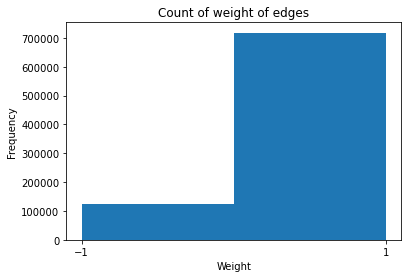

In [18]:
epi_Stats = stats(epi_csv,epi_graph)

Nodes = 7115
Edges = 103689
   From  Outdegree  Pos_out  Neg_out  Indegree  Pos_in  Neg_in
0     3         23     23.0      0.0        31    31.0     0.0
1     4         29     29.0      0.0         0     0.0     0.0
2     5         23     23.0      0.0         0     0.0     0.0
3     6        302    302.0      0.0        20    20.0     0.0
4     7         24     24.0      0.0         0     0.0     0.0
              From    Outdegree      Pos_out  Neg_out     Indegree  \
count  7115.000000  7115.000000  7115.000000   7115.0  7115.000000   
mean   4006.232326    14.573296    14.573296      0.0    14.573296   
std    2387.369622    42.282087    42.282087      0.0    31.730957   
min       3.000000     0.000000     0.000000      0.0     0.000000   
25%    1928.500000     1.000000     1.000000      0.0     0.000000   
50%    3925.000000     2.000000     2.000000      0.0     0.000000   
75%    6043.500000     9.000000     9.000000      0.0    13.000000   
max    8297.000000   893.000000   

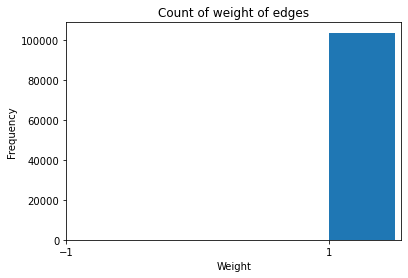

In [18]:
wiki_Stats = stats(wiki_csv,wiki_graph)

Nodes = 5881
Edges = 35592
   From  Outdegree  Pos_out  Neg_out  Indegree  Pos_in  Neg_in
0   1.0        215    324.0   -109.0       226   513.5  -287.5
1   2.0         45     94.0    -49.0        41    82.0   -41.0
2   3.0          0      0.0      0.0        21     7.5    13.5
3   4.0         63    119.0    -56.0        54   111.0   -57.0
4   5.0          3      5.0     -2.0         3     5.0    -2.0
              From    Outdegree      Pos_out      Neg_out     Indegree  \
count  5881.000000  5881.000000  5881.000000  5881.000000  5881.000000   
mean   3006.068186     6.052032     6.088420    -0.036388     6.052032   
std    1721.384064    21.088387    24.428041    19.172023    17.675082   
min       1.000000     0.000000  -301.000000  -179.000000     0.000000   
25%    1513.000000     1.000000     1.000000    -1.500000     1.000000   
50%    3002.000000     2.000000     2.000000     0.000000     2.000000   
75%    4496.000000     4.000000     5.500000     0.000000     5.000000   
max

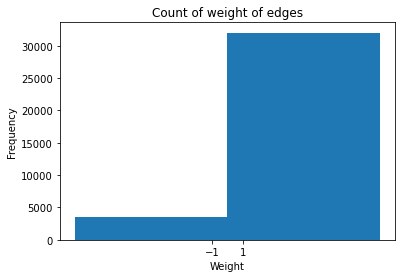

In [19]:
bitcoin_Stats = stats(bitcoin_csv,bitcoin_graph)

In [92]:
def degreeDistribution(data,graph):
    
    degree_sequence = sorted([d for n, d in graph.in_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    #print(degreeCount)
    deg, cnt = zip(*degreeCount.items())
    #deg, cnt = np.array(deg), deg.array(cnt)
#     print(len(deg))
#     deg = deg[0:100]
#     cnt = cnt[0:100]
#     print(len(deg))
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot(deg,cnt,color="#3F5D7D")
    plt.xlabel('In-Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Actual Plot(Epinion)')
    plt.grid()
    plt.xlim([0, 1000])
    plt.show()
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(deg,(np.log(cnt)),color = 'r')
    #plt.plot(n1)
    #plt.plot(deg,(np.log(cnt)),color="#3F5D7D")
    plt.xlabel('In-Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 800])
    plt.grid()
    plt.show()
    
    # Degree distribtion for out-degree
    degree_sequence = sorted([d for n, d in graph.out_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    #print(degreeCount)
    deg, cnt = zip(*degreeCount.items())
    #deg, cnt = np.array(deg), deg.array(cnt)
    deg, cnt = deg[0:1000], cnt[0:1000]
    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot(deg,cnt,color="#3F5D7D")
    plt.xlabel('Out-Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 1000])
    plt.grid()
    plt.show()

    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(deg,(np.log(cnt)),color = 'r')
    #plt.plot(deg,(np.log(cnt)),color="#3F5D7D")
    plt.xlabel('Out-Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 800])
    plt.grid()
    plt.show()



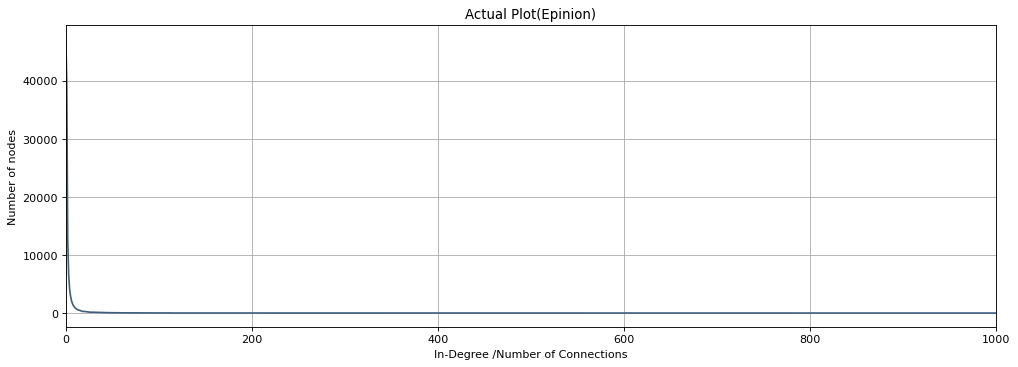

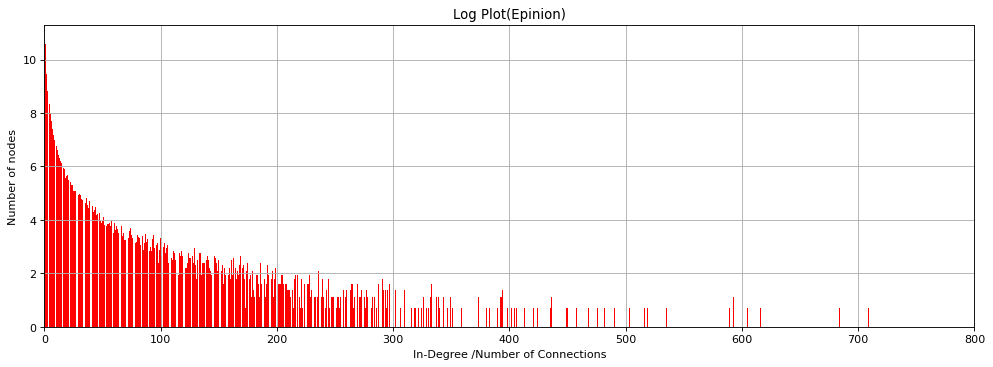

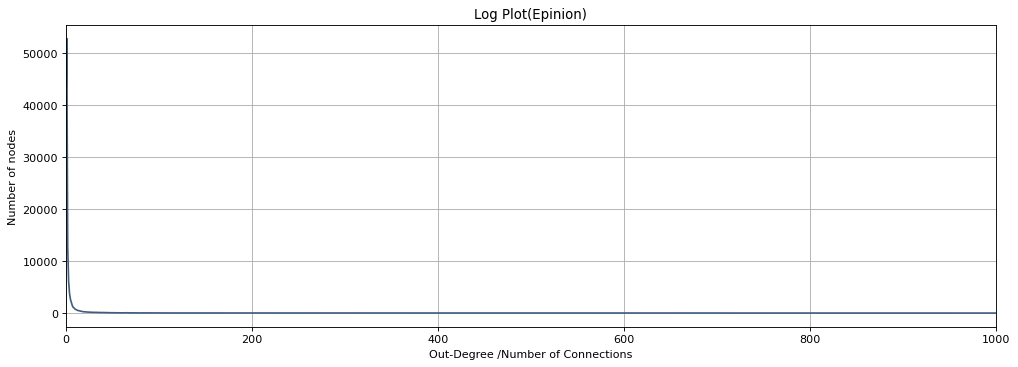

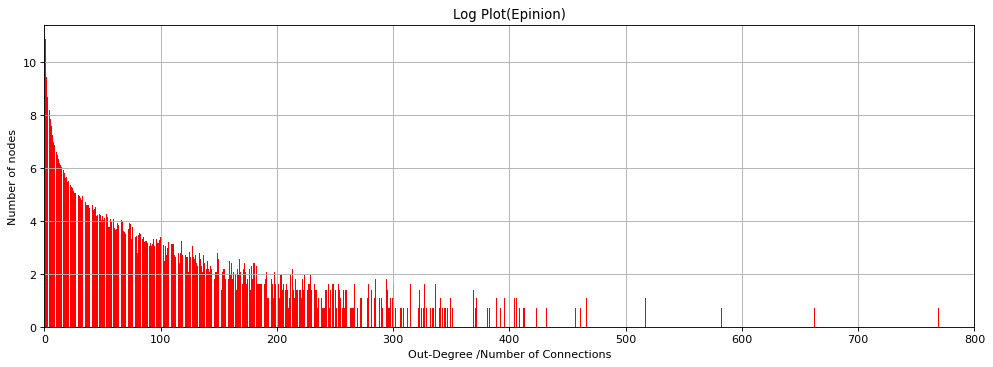

In [93]:
degreeDistribution(epi_csv, epi_graph)

Counter({0: 4734, 1: 78, 5: 54, 3: 51, 2: 45, 13: 44, 12: 44, 11: 44, 10: 44, 7: 44, 6: 42, 4: 40, 8: 39, 22: 38, 9: 38, 18: 36, 17: 35, 14: 35, 15: 34, 34: 33, 47: 31, 48: 30, 38: 30, 29: 30, 24: 30, 57: 29, 46: 29, 43: 29, 21: 29, 54: 28, 39: 28, 33: 28, 28: 28, 30: 27, 20: 27, 53: 26, 51: 26, 31: 26, 26: 26, 50: 24, 49: 24, 16: 24, 60: 23, 42: 23, 40: 23, 64: 22, 37: 22, 35: 22, 25: 22, 63: 21, 61: 21, 58: 21, 45: 21, 27: 21, 44: 20, 41: 20, 74: 19, 65: 19, 55: 19, 52: 19, 32: 19, 23: 19, 19: 19, 59: 18, 56: 17, 71: 15, 82: 14, 81: 14, 77: 14, 69: 14, 67: 14, 72: 13, 73: 12, 66: 12, 62: 12, 90: 11, 88: 11, 79: 11, 101: 10, 78: 10, 36: 10, 75: 9, 97: 8, 93: 8, 85: 8, 83: 8, 70: 8, 68: 8, 105: 7, 104: 7, 89: 7, 80: 7, 117: 6, 100: 6, 95: 6, 94: 6, 87: 6, 76: 6, 110: 5, 107: 5, 99: 5, 84: 5, 162: 4, 149: 4, 115: 4, 92: 4, 181: 3, 145: 3, 136: 3, 135: 3, 128: 3, 122: 3, 118: 3, 116: 3, 113: 3, 109: 3, 108: 3, 86: 3, 195: 2, 193: 2, 192: 2, 186: 2, 175: 2, 165: 2, 164: 2, 158: 2, 153: 2,

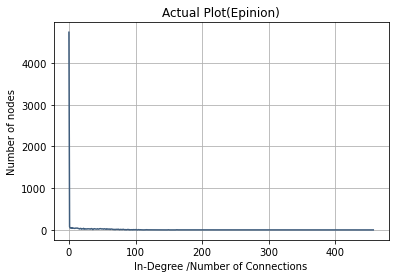

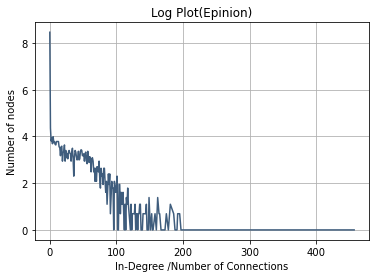

Counter({1: 2382, 0: 1005, 2: 704, 3: 401, 4: 279, 5: 162, 6: 159, 7: 131, 8: 110, 9: 91, 10: 79, 11: 75, 12: 68, 13: 61, 15: 57, 14: 56, 16: 48, 18: 44, 19: 40, 20: 32, 17: 32, 21: 31, 22: 30, 24: 29, 29: 28, 31: 25, 28: 25, 41: 24, 26: 24, 44: 23, 39: 23, 30: 23, 23: 23, 33: 22, 27: 20, 25: 19, 35: 18, 50: 17, 45: 16, 36: 16, 32: 16, 37: 15, 34: 15, 42: 14, 47: 13, 46: 13, 68: 12, 52: 12, 48: 12, 38: 12, 79: 11, 49: 11, 81: 10, 43: 10, 40: 10, 80: 9, 77: 9, 66: 9, 61: 9, 95: 8, 89: 8, 75: 8, 65: 8, 62: 8, 57: 8, 55: 8, 54: 8, 53: 8, 93: 7, 70: 7, 64: 7, 63: 7, 76: 6, 69: 6, 60: 6, 51: 6, 156: 5, 139: 5, 123: 5, 122: 5, 121: 5, 101: 5, 100: 5, 91: 5, 88: 5, 86: 5, 72: 5, 59: 5, 58: 5, 56: 5, 146: 4, 142: 4, 114: 4, 113: 4, 105: 4, 103: 4, 99: 4, 98: 4, 90: 4, 74: 4, 71: 4, 164: 3, 145: 3, 144: 3, 135: 3, 124: 3, 117: 3, 115: 3, 112: 3, 108: 3, 104: 3, 102: 3, 94: 3, 87: 3, 85: 3, 84: 3, 82: 3, 73: 3, 67: 3, 271: 2, 244: 2, 241: 2, 238: 2, 232: 2, 230: 2, 227: 2, 214: 2, 199: 2, 191: 2

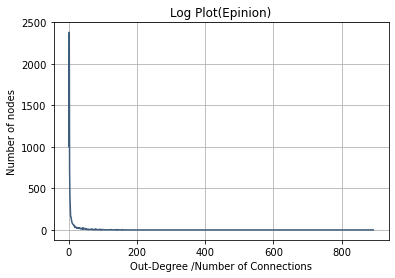

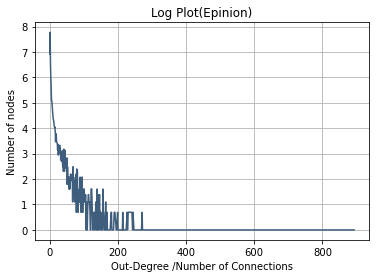

In [26]:
degreeDistribution(wiki_csv, wiki_graph)

Counter({1: 2427, 2: 1042, 3: 565, 4: 335, 5: 235, 6: 189, 7: 142, 8: 95, 9: 87, 10: 75, 11: 68, 12: 46, 16: 40, 13: 39, 14: 38, 18: 30, 15: 27, 19: 24, 0: 23, 20: 22, 21: 21, 17: 21, 29: 15, 26: 13, 23: 13, 25: 12, 27: 11, 24: 11, 37: 10, 31: 9, 54: 8, 38: 7, 36: 7, 33: 7, 32: 7, 28: 7, 53: 6, 34: 6, 22: 6, 47: 5, 30: 5, 55: 4, 48: 4, 44: 4, 41: 4, 35: 4, 82: 3, 69: 3, 64: 3, 63: 3, 52: 3, 51: 3, 50: 3, 46: 3, 45: 3, 128: 2, 118: 2, 115: 2, 100: 2, 96: 2, 85: 2, 81: 2, 80: 2, 74: 2, 71: 2, 68: 2, 58: 2, 57: 2, 43: 2, 42: 2, 39: 2, 535: 1, 412: 1, 311: 1, 279: 1, 264: 1, 226: 1, 222: 1, 216: 1, 203: 1, 191: 1, 180: 1, 179: 1, 165: 1, 164: 1, 158: 1, 145: 1, 144: 1, 136: 1, 134: 1, 133: 1, 132: 1, 129: 1, 123: 1, 117: 1, 113: 1, 110: 1, 105: 1, 103: 1, 99: 1, 98: 1, 95: 1, 93: 1, 92: 1, 84: 1, 83: 1, 79: 1, 72: 1, 66: 1, 65: 1, 62: 1, 61: 1, 60: 1, 59: 1, 56: 1, 49: 1, 40: 1})


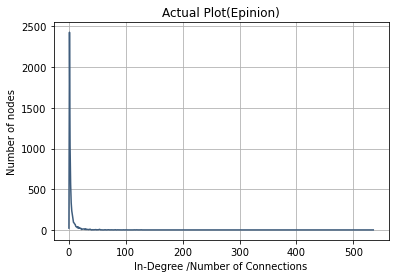

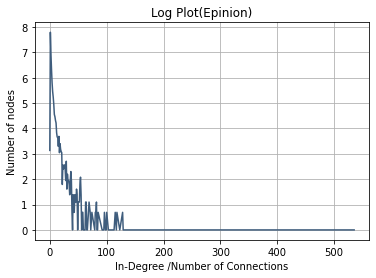

Counter({1: 1793, 0: 1067, 2: 821, 3: 479, 4: 311, 5: 235, 6: 147, 8: 120, 7: 116, 9: 77, 10: 70, 11: 59, 12: 54, 13: 40, 17: 28, 14: 27, 16: 26, 21: 21, 15: 20, 18: 19, 28: 18, 19: 16, 26: 14, 20: 14, 32: 13, 27: 13, 22: 13, 25: 12, 23: 12, 31: 11, 24: 11, 45: 8, 56: 7, 36: 7, 35: 7, 38: 6, 37: 6, 29: 6, 63: 5, 44: 5, 43: 5, 42: 5, 40: 5, 34: 5, 30: 5, 69: 4, 65: 4, 59: 4, 49: 4, 47: 4, 46: 4, 74: 3, 67: 3, 58: 3, 54: 3, 53: 3, 50: 3, 264: 2, 172: 2, 104: 2, 90: 2, 86: 2, 84: 2, 79: 2, 78: 2, 70: 2, 66: 2, 60: 2, 55: 2, 52: 2, 51: 2, 48: 2, 39: 2, 763: 1, 406: 1, 404: 1, 397: 1, 293: 1, 232: 1, 215: 1, 212: 1, 210: 1, 203: 1, 202: 1, 200: 1, 197: 1, 190: 1, 186: 1, 170: 1, 169: 1, 167: 1, 164: 1, 162: 1, 154: 1, 141: 1, 138: 1, 133: 1, 128: 1, 127: 1, 125: 1, 115: 1, 108: 1, 107: 1, 106: 1, 105: 1, 100: 1, 94: 1, 93: 1, 92: 1, 89: 1, 83: 1, 82: 1, 80: 1, 77: 1, 76: 1, 75: 1, 71: 1, 64: 1, 62: 1, 41: 1, 33: 1})


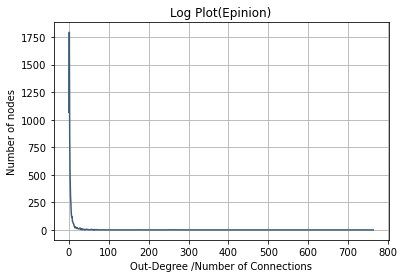

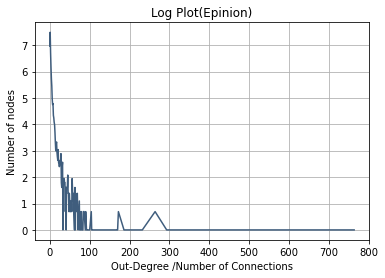

In [27]:
degreeDistribution(bitcoin_csv, bitcoin_graph)

In [56]:
def degreeCentrality(graph, name):
    # Degree centrality stats
    print("In-degree")
    in_degree_centrality_nodes = nx.in_degree_centrality(graph)
    in_degree_centrality_nodes = collections.Counter(in_degree_centrality_nodes)
    for k, v in in_degree_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_indegreecentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in in_degree_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count))  
    print("\n Out-degree \n")
    out_degree_centrality_nodes = nx.out_degree_centrality(graph)
    out_degree_centrality_nodes = collections.Counter(out_degree_centrality_nodes)
    for k, v in out_degree_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_outdegreecentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in out_degree_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
    # degree_centrality_nodes = nx.degree_centrality(graph)
    # degree_centrality_nodes = collections.Counter(degree_centrality_nodes)
    # for k, v in degree_centrality_nodes.most_common(100):
    #   print (k,v)
    inDegreeCentrality = pd.read_csv(name+'_indegreecentrality.csv', delimiter=',')
    outDegreeCentrality = pd.read_csv(name+'_outdegreecentrality.csv', delimiter=',')
    
    return inDegreeCentrality, outDegreeCentrality

In [30]:
def H_value(max_value,in_values):
  sum = np.sum(max_value - np.array(in_values))
  return sum

# Sample modified degree centrality
# According to the proposed approach the node with least
# degree centrality (as H value will be high for the most
# influential node and it is in the denominator) can be
# considered as the node with most number of connections and
# hence the most influential node.

# G = nx.gn_graph(10)
# G = nx.petersen_graph()
# subax2 = plt.subplot(121)
# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

def enhancedCentrality(graph, name):
  A = nx.adjacency_matrix(graph)
  B = A.astype(np.bool_)
  C = B.toarray()

  in_degree_centrality_nodes = nx.in_degree_centrality(graph)
  
  in_values = list(in_degree_centrality_nodes.values())
  in_values = [i*(len(in_values)-1) for i in in_values]
  max_value = max(in_values)
  sum = H_value(max_value,in_values)
  print(sum)
  clustering_array = nx.clustering(graph)
  clustering_values = list(clustering_array.values())
  clustering_values = [float(i) for i in clustering_values]
  with open(name+'_clusteringCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('col1\n')
    for val in clustering_values:  
      fp.write('{}\n'.format(val))

  enhanced_degree_centrality = []
  if name == 'Epinion':
    for i in range(len(C)):
      #temp = (float(max_value - in_degree_centrality_nodes[i])) * float(clustering_array[i]) /float(sum) 
      temp = (float(max_value - in_degree_centrality_nodes[i])) 
      enhanced_degree_centrality.append((i,temp))
  else:
    for i,j in in_degree_centrality_nodes:
      temp = (float(max_value - j)) * float(clustering_array[i]) /float(sum) 
      enhanced_degree_centrality.append((i,temp))
    
  enhanced_degree_centrality = [ (i,'%.12f' % elem) for i,elem in enhanced_degree_centrality ]
  # print(enhanced_degree_centrality)
  file = open(name+'______enhancedInDegreeCentrality.csv', 'w+', newline ='\n') 
  with file:     
    write = csv.writer(file) 
    write.writerows(enhanced_degree_centrality) 
    
  enhancedInDegreeCentrality = pd.read_csv(name+'_enhancedInDegreeCentrality.csv', delimiter=',')
  clusteringCentrality = pd.read_csv(name+'_clusteringCentrality.csv', delimiter=',')
    
  return enhancedInDegreeCentrality, clusteringCentrality




# def H_value(max_value,in_values):
#   sum = np.sum(max_value - np.array(in_values))
#   return sum

# # Sample modified degree centrality
# # According to the proposed approach the node with least
# # degree centrality (as H value will be high for the most
# # influential node and it is in the denominator) can be
# # considered as the node with most number of connections and
# # hence the most influential node.

# # G = nx.gn_graph(10)
# # G = nx.petersen_graph()
# # subax2 = plt.subplot(121)
# # nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

# def enhancedCentrality(graph, name):
#   A = nx.adjacency_matrix(graph)
#   B = A.astype(np.bool_)
#   C = B.toarray()
#   in_degree_centrality_nodes = nx.in_degree_centrality(graph)
#   in_values = list(in_degree_centrality_nodes.values())
#   in_values = [i*(len(in_values)-1) for i in in_values]
#   max_value = max(in_values)
#   sum = H_value(max_value,in_values)
#   clustering_array = nx.clustering(graph)
#   clustering_values = list(clustering_array.values())
#   clustering_values = [float(i) for i in clustering_values]
#   with open(name+'_clusteringCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
#     fp.write('col1\n')  
#     for val in clustering_values:  
#       fp.write('{}\n'.format(val)) 

#   enhanced_degree_centrality = []
#   for i in range(len(C)):
#     temp = (float(max_value - in_values[i])) * float(clustering_values[i]) /float(sum) 
#     enhanced_degree_centrality.append(temp)
    
#   enhanced_degree_centrality = [float(i) for i in enhanced_degree_centrality]
#   with open(name+'_enhancedInDegreeCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
#     fp.write('col1\n')  
#     for val in enhanced_degree_centrality:  
#       fp.write('{}\n'.format(val)) 
    
#   enhancedInDegreeCentrality = pd.read_csv(name+'_enhancedInDegreeCentrality.csv', delimiter=',')
#   clusteringCentrality = pd.read_csv(name+'_clusteringCentrality.csv', delimiter=',')
    
#   return enhancedInDegreeCentrality, clusteringCentrality

In [58]:
def eigenVectorCentrality(graph, name):
    # Eigen Vector centrality stats
    print("Eigen Vector centrality")
    eigenvector_centrality_nodes = nx.eigenvector_centrality_numpy(graph)
    eigenvector_centrality_nodes = collections.Counter(eigenvector_centrality_nodes)
    for k, v in eigenvector_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_eigenvectorcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in eigenvector_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    eigenvectorCentrality = pd.read_csv(name+'_eigenvectorcentrality.csv', delimiter=',')

    return eigenvectorCentrality


In [59]:
def khatzCentrality(graph,name):
    # Katz centrality stats
    # Not running on colab
    print("Katz centrality")
    katz_centrality_numpy_nodes = nx.katz_centrality_numpy(graph)
    katz_centrality_numpy_nodes = collections.Counter(katz_centrality_numpy_nodes)
#    for k, v in katz_centrality_numpy_nodes.most_common(10):
#      print ((k, v))
    with open(name+'_khatzcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in katz_centrality_numpy_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    khatzCentrality = pd.read_csv(name+'_khatzcentrality.csv', delimiter=',')

    return khatzCentrality

In [4]:
def closenessCentrality(graph, name):
    # Closeness centrality stats
    # Not running on colab
    print("closeness centrality ")
    closeness_centrality_nodes = nx.closeness_centrality(graph)
    closeness_centrality_nodes = collections.Counter(closeness_centrality_nodes)
#    for k, v in closeness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_closenesscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in closeness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    closenessCentrality = pd.read_csv(name+'_closenesscentrality.csv', delimiter=',')

    return closenessCentrality

In [4]:
def betweenessCentrality(graph,name):
    # Betweenness centrality stats
    # Not running on colab
    print("Betweenness centrality ")
    betweenness_centrality_nodes = nx.betweenness_centrality(graph)
    betweenness_centrality_nodes = collections.Counter(betweenness_centrality_nodes)
#    for k, v in betweenness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_betweennessscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in betweenness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    betweennessCentrality = pd.read_csv(name+'_betweennessscentrality.csv', delimiter=',')

    return betweennessCentrality

In [62]:
def degreeRelationship(Stats, graph, name):
    # Out degree and indegree relationship, relationship between positive and negative weighted outgoing 
    # edges in the network and relationship between positive and negative ingoing edges.
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Pos_out'],Stats['Neg_out'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Positive Outdegree')
    plt.ylabel('Negativetive Outdegree')
    plt.title(name+' Outdegree(Pos-Neg) relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Pos_in'],Stats['Neg_in'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Positive Indegree')
    plt.ylabel('Negativetive Indegree')
    plt.title(name+' Indegree(Pos-Neg) relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Outdegree'],Stats['Indegree'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Indegree')
    plt.title(name+' Outdegree-Indegree relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    
    plt.figure(figsize=(5, 5), dpi=80)
    Deg_cor = nx.average_neighbor_degree(graph,target='out')
    dict_list = []
    for key, value in Deg_cor.items():
        temp = [key,value]
        temp[0] = graph.degree(key,'out')
        dict_list.append(temp)
    dfa11 = pd.DataFrame(dict_list,columns =['Outdegree','Average neighbors outdegree'])
    dfa21 = dfa11.groupby('Outdegree',as_index=False)['Average neighbors outdegree'].mean()
    plt.plot(dfa11['Outdegree'],dfa11['Average neighbors outdegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa21['Outdegree'],dfa21['Average neighbors outdegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Average neighbors outdegree')
    plt.title(name+' Outdegree-Neighbour outdegree relationship')
    plt.legend(['Node','Mean at same outdegree'])
    plt.grid()
    plt.show()
    
    
    plt.figure(figsize=(5, 5), dpi=80)
    Deg_cor = nx.average_neighbor_degree(graph,target='in')
    dict_list = []
    for key, value in Deg_cor.items():
        temp = [key,value]
        temp[0] = graph.degree(key,'in')
        dict_list.append(temp)
    dfa12 = pd.DataFrame(dict_list,columns =['Indegree','Average neighbors indegree'])
    # group same indegree values and take their mean
    dfa22 = dfa12.groupby('Indegree',as_index=False)['Average neighbors indegree'].mean()
    plt.plot(dfa12['Indegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa22['Indegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Indegree')
    plt.ylabel('Average neighbors indegree')
    plt.title(name+' Indegree-Neighbour indegree relationship')
    plt.legend(['Node','Mean at same indegree'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(dfa12['Indegree'],dfa11['Average neighbors outdegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa22['Indegree'],dfa21['Average neighbors outdegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Indegree')
    plt.ylabel('Average neighbors outdegree')
    plt.title(name+' Indegree-Neighbour outdegree relationship')
    plt.legend(['Node','Mean at same indegree'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(dfa11['Outdegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa21['Outdegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Average neighbors indegree')
    plt.title(name+' Outdegree-Neighbour indegree relationship')
    plt.legend(['Node','Mean at same outdegree'])
    plt.grid()
    plt.show()
    
    
    
    print('In-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','in')))
    print('Out-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','out')))
    print('In-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','out')))
    print('Out-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','in')))
    print('Graph assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph)))
    

In [6]:
def weakConnected(graph):
    weak = nx.weakly_connected_components(graph)
    weak_list = [c for c in sorted(weak,key=len, reverse=True)]
    weak_nodes = weak_list[0]
    weak_graph = graph.subgraph(weak_nodes)
    return weak_graph

In [207]:
def powerLaw(Stats, graph):
    import math
    pos = Stats['Indegree'][Stats['Indegree'] != 0]
    pos = pos.transform(lambda x: math.floor(math.log(x)) )

    prob = pos.value_counts(normalize=True)
    threshold = 0.0001
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob.plot(kind='bar',log=True,color='r')
    plt.title('Indegree')
    plt.grid()
    
    import igraph
    pos = Stats['Indegree'][Stats['Indegree'] != 0]
    print(igraph.power_law_fit(pos))

In [ ]:
def communities(graph):
    SCC = max(nx.strongly_connected_components(graph), key=len)
    print('Size of maximal strongly connected component is ' + str(len(SCC)))
    WCC = max(nx.weakly_connected_components(graph), key=len)
    print('Size of maximal weakly connected component is ' + str(len(WCC)))
    DIF = list(set(WCC)-set(SCC))
    OUT_C = []
    IN_C = []
    IN = 0
    OUT = 0
    for index, node1 in enumerate(DIF):
        for index2, node2 in enumerate(SCC):

            if graph.has_edge(node1,node2):
                OUT+=1
                OUT_C.append(node2)
                break
            elif graph.has_edge(node2,node1):
                IN+=1
                IN_C.append(node1)
                break


    TND = len(DIF)-IN-OUT
    print(IN,OUT,TND)
    
    SCC = max(nx.strongly_connected_components(graph), key=len)
    scc_com = graph.subgraph(SCC).copy()
    scc2 = nx.Graph(scc_com)

    # Removing the weights.

    for u,v,d in scc2.edges(data=True):
        d['weight']=1

    communities =community_louvain.best_partition(scc2,random_state=5)
    
    print(set(communities.values()))
    # node numver, community it belongs to
    # find size of all communities
    # group by val -> key.sum()
    
    ind_graph = community_louvain.induced_graph(communities, scc2)

    inv_map = dict()
    for key, value in communities.items():
        inv_map.setdefault(value, list()).append(key)

    # Removing the small communities

    inv_map2 = {key:val for key, val in inv_map.items() if len(val) >= 100}
    sizes = np.array([len(inv_map2[k]) for k in list(inv_map2.keys())])

    # Removing edges from the graph:

    inv_keys = [key for key in inv_map2]
    ind_nodes = list(ind_graph.nodes())
    for node in ind_nodes:
        if node not in inv_keys:
            ind_graph.remove_node(node)
            
    print(community_louvain.modularity(communities,scc2))
    print(sizes)

In [27]:
def richClubEffect(Stats, graph):
    
    # We want to see the rich club effect in the 100 edges with the highest indegree.
    picked = 100
    rce1 = Stats[['From','Indegree']].sort_values(by=['Indegree'], ascending=False)[0:picked]
    rich = list(rce1.From.values)
    rece_graph = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 
    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1

        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)

    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density(+ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density(+ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    #plt.legend(loc="upper right")
    #plt.ylim((0,1))
    #plt.xlim((-2,picked-2))
    #plt.show()

    # Checking the one sidedness
    print(nx.reciprocity(rece_graph))
    
    
    
    # We want to see the rich club effect in the 100 edges with the highest negative_degree.
    picked = 100
    rce2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[4:picked+4]
    rich = list(rce2.From.values)
    rece_graph2 = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 

    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1


        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


    plt.plot( [i for i in range(0,picked)],densities[0,],'g-',label='Positive edge density(-ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'m-',label='Negative edge density(-ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    plt.legend(loc="upper right")
    plt.ylim((0,1))
    plt.xlim((-2,picked-2))
    plt.title('Rich Club Effect', fontsize = 20)
    plt.grid()
    plt.ylim([0,0.6])
    plt.xlabel('Node Number')
    plt.ylabel('Density')
    plt.show()
    
    # Checking the one sidedness
    print(nx.reciprocity(rece_graph2))
    
    
    
#     # We want to see the rich club effect in the 100 edges with the highest outdegree.
#     picked = 100
#     rce3 = Stats[['From','Outdegree']].sort_values(by=['Outdegree'], ascending=False)[0:picked]
#     rich = list(rce3.From.values)
#     rece_graph3 = graph.subgraph(rich).copy()
#     # Dropping first value

#     densities = np.zeros((3,picked))
#     pos_edges = 0
#     neg_edges = 0 
#     for rank, node1 in enumerate(rich[1::]):

#         for rank2, node2 in enumerate(rich[:rank+1]): 
#             if graph.has_edge(node1, node2):
#                 if graph[node1][node2]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1
#             if graph.has_edge(node2, node1):
#                 if graph[node2][node1]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1

#         densities[0][rank] = pos_edges/(rank+2)/(rank+1)
#         densities[1][rank] = neg_edges/(rank+2)/(rank+1)
#         densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


#     plt.plot( [i for i in range(0,picked)],densities[0,],'g-',label='Positive edge outdegree density')
#     plt.plot( [i for i in range(0,picked)],densities[1,],'m-',label='Negative edge outdegree density')
#     #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
#     plt.legend(loc="upper right")
#     plt.ylim((0,1))
#     plt.xlim((-2,picked-2))
#     plt.title('Rich Club Effect')
#     plt.grid()
#     plt.ylim([0,0.6])
#     plt.show()

    # Checking the one sidedness
    #print(nx.reciprocity(rece_graph3))
    
    
#     # We want to see the rich club effect in the 100 edges with the highest negitive outdegree.
#     picked = 100
#     rce4 = Stats[['From','Neg_out']].sort_values(by=['Neg_out'], ascending=False)[0:picked]
#     rich = list(rce4.From.values)
#     rece_graph4 = graph.subgraph(rich).copy()
#     # Dropping first value

#     densities = np.zeros((3,picked))
#     pos_edges = 0
#     neg_edges = 0 
#     for rank, node1 in enumerate(rich[1::]):

#         for rank2, node2 in enumerate(rich[:rank+1]): 
#             if graph.has_edge(node1, node2):
#                 if graph[node1][node2]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1
#             if graph.has_edge(node2, node1):
#                 if graph[node2][node1]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1

#         densities[0][rank] = pos_edges/(rank+2)/(rank+1)
#         densities[1][rank] = neg_edges/(rank+2)/(rank+1)
#         densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


#     plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
#     plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
#     plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
#     plt.legend(loc="upper right")
#     plt.ylim((0,1))
#     plt.xlim((-2,picked-2))
#     plt.show()

#     # Checking the one sidedness
#     print(nx.reciprocity(rece_graph4))

0.6515615431720759


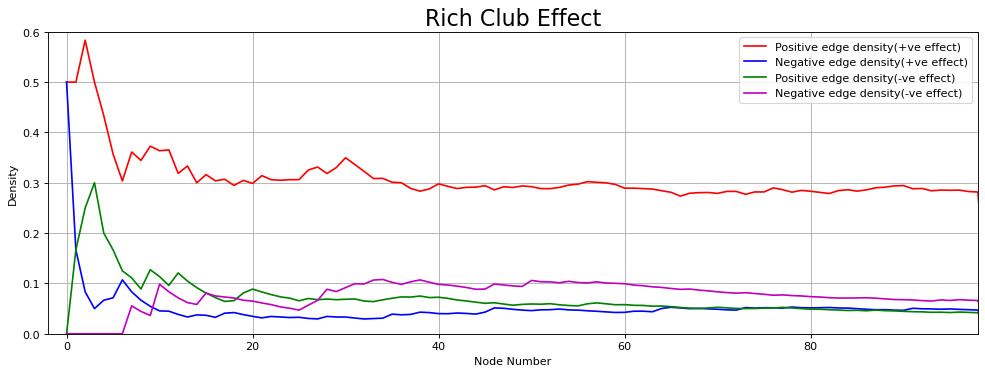

0.38847583643122674


In [28]:
richClubEffect(epi_Stats, epi_graph)

In [ ]:
def communitiesNewCode(graph):
    # compute the best partition
    partition = community_louvain.best_partition(graph)
    print(partition)
#     # draw the graph
#     pos = nx.spring_layout(graph)
#     # color the nodes according to their partition
#     cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
#     nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=40,
#                            cmap=cmap, node_color=list(partition.values()))
#     nx.draw_networkx_edges(graph, pos, alpha=0.5)
#     plt.show()

In [54]:
epic1, epic2  = degreeCentrality(epi_graph, 'Epinion')

In-degree
(25, 0.02638306265029167)
(2292, 0.013904587072451015)
(366, 0.011879205322126727)
(2293, 0.011317863563609884)
(433, 0.010657907712380621)
(161, 0.010293794139288614)
(5, 0.010286208439849197)
(1352, 0.009838652172923604)
(450, 0.00977796657740827)
(1089, 0.009550395594225766)

 Out-degree 

(68214, 0.0157023978395928)
(12168, 0.015672055041835133)
(112586, 0.015603783746880382)
(72164, 0.014701085513589781)
(167, 0.014359729038816025)
(321, 0.013502545002161925)
(353, 0.013221874122903503)
(1652, 0.013168774226827586)
(966, 0.011439234754640553)
(655, 0.009375924507119179)


In [57]:
epic3 = eigenVectorCentrality(epi_graph, 'Epinion')

Eigen Vector centrality
(11714, 0.09156136036869988)
(11824, 0.09070215020780716)
(11841, 0.09018662392050499)
(11693, 0.08876798592399575)
(11689, 0.08697265655065996)
(56140, 0.08660357470086985)
(11704, 0.08637572445770726)
(11853, 0.08631141183323317)
(11863, 0.08629382296174824)
(11722, 0.08560266065085596)


In [8]:
epic6 = closenessCentrality(epi_weak_graph, 'Epinion')

closeness centrality 


In [ ]:
epic7 = betweenessCentrality(epi_weak_graph, 'Epinion')

Betweenness centrality 


In [31]:
epic4, epic5 = enhancedCentrality(epi_graph, 'Epinion')

457656412.0


In [70]:
wikic1, wikic2  = degreeCentrality(wiki_graph, 'Wiki')
wikic3  = eigenVectorCentrality(wiki_graph, 'Wiki')
wikic4, wikic5  = enhancedCentrality(wiki_graph, 'Wiki')

In-degree
(4037, 0.06423952769187517)
(15, 0.0507450098397526)
(2398, 0.04779308405960079)
(2625, 0.04652797301096429)
(1297, 0.04343547933651954)
(2565, 0.03851560303626651)
(762, 0.03823446724768063)
(2328, 0.03739105988192297)
(5254, 0.03725049198763002)
(3352, 0.037109924093337084)

 Out-degree 

(2565, 0.12552712960359855)
(766, 0.10865898228844531)
(11, 0.10444194545965702)
(457, 0.10289569862243464)
(2688, 0.08687095867303908)
(1166, 0.08420016868147315)
(1549, 0.08251335394995783)
(1151, 0.06634804610626932)
(1374, 0.0649423671633399)
(1133, 0.056086589822884454)
Eigen Vector centrality
(2398, 0.1171969461904778)
(4037, 0.10896914427330916)
(15, 0.09818046327225055)
(4191, 0.09568565337813759)
(2625, 0.0954930850096367)
(1549, 0.09502096303167477)
(2328, 0.09481066214704542)
(3089, 0.09311134675778972)
(5412, 0.09050188238864589)
(2066, 0.09045190783251392)
3147866.0


TypeError: cannot unpack non-iterable numpy.int64 object

In [66]:
bitc1, bitc2  = degreeCentrality(bitcoin_graph, 'Bitcoin')
bitc3  = eigenVectorCentrality(bitcoin_graph, 'Bitcoin')
bitc4, bitc5  = enhancedCentrality(bitcoin_graph, 'Bitcoin')

In-degree
(35.0, 0.09098639455782312)
(2642.0, 0.07006802721088434)
(1810.0, 0.05289115646258503)
(2028.0, 0.047448979591836735)
(905.0, 0.044897959183673466)
(1.0, 0.03843537414965986)
(4172.0, 0.03775510204081632)
(7.0, 0.03673469387755102)
(4197.0, 0.03452380952380952)
(13.0, 0.03248299319727891)

 Out-degree 

(35.0, 0.12976190476190474)
(2642.0, 0.06904761904761904)
(1810.0, 0.06870748299319727)
(2125.0, 0.06751700680272109)
(2028.0, 0.049829931972789114)
(905.0, 0.044897959183673466)
(4172.0, 0.044897959183673466)
(7.0, 0.03945578231292517)
(1.0, 0.036564625850340135)
(3129.0, 0.03605442176870748)
Eigen Vector centrality
(2642.0, 0.20221058479145856)
(905.0, 0.19012652264436103)
(1810.0, 0.16982089076458162)
(35.0, 0.1547228059340944)
(2028.0, 0.15008323742173188)
(4172.0, 0.14632041848826016)
(1.0, 0.1354079375826993)
(4291.0, 0.13529331666497174)
(1334.0, 0.131384736444338)
(4197.0, 0.12796758064486585)
3110742.9999999995


KeyError: 0

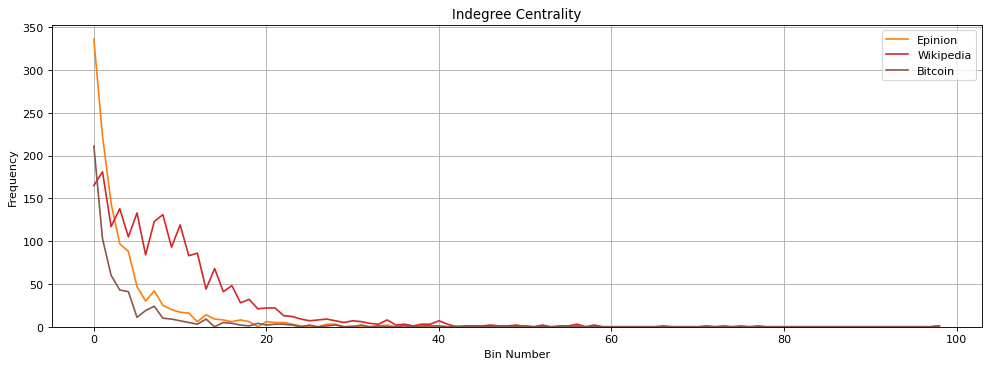

In [190]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic1['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic1['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc1['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.002, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Indegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

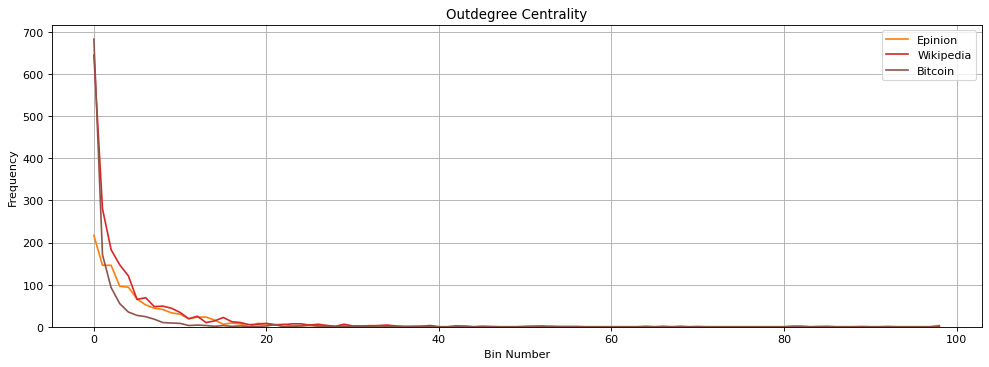

In [189]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic2['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic2['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc2['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Outdegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

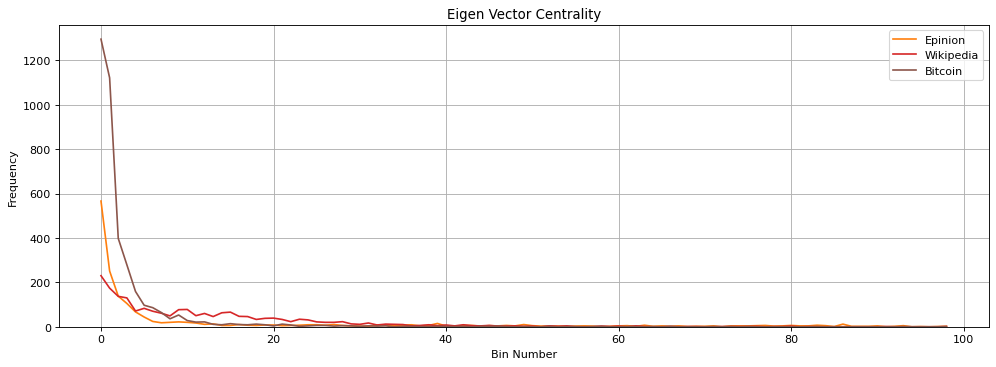

In [188]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic3['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic3['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc3['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Eigen Vector Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

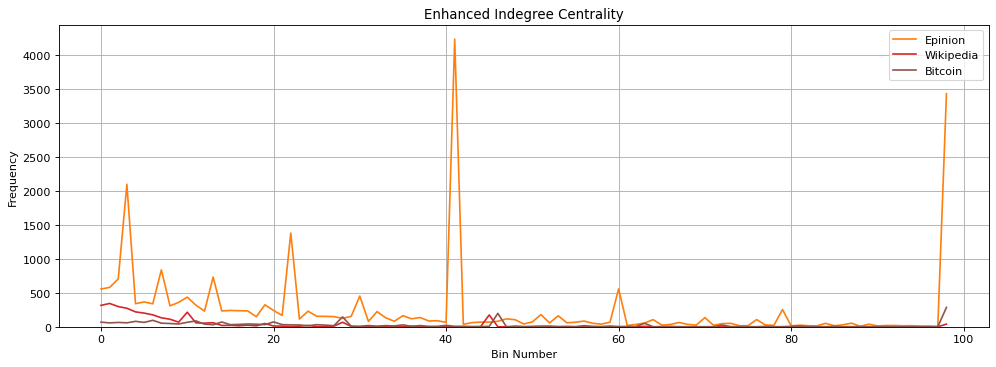

In [187]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic4['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.000001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic4['col1']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.00001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc4['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.00001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Enhanced Indegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

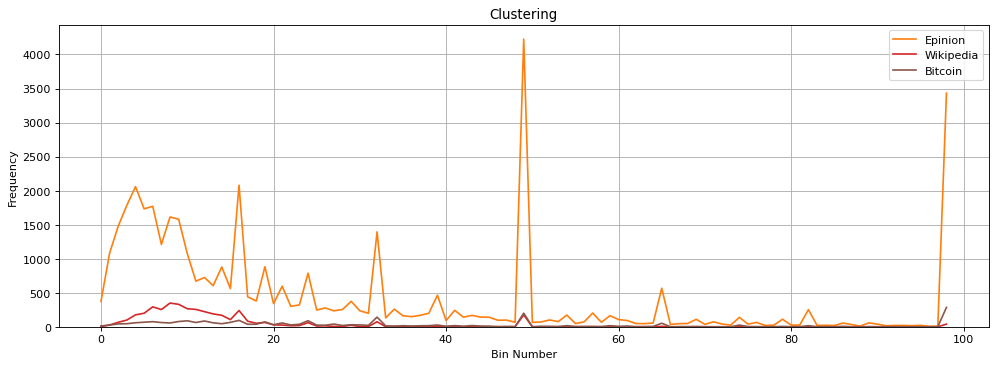

In [186]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic5['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic5['col1']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc5['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Clustering')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

In [7]:
epi_weak_graph = weakConnected(epi_graph)

In [18]:
epi_weak_graph = weakConnected(epi_graph)
wiki_weak_graph = weakConnected(wiki_graph)
bit_weak_graph = weakConnected(bitcoin_graph)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 1.704944
Cutoff (xmin)     = 1.000000

Log-likelihood    = -197839.749790

H0: data was drawn from the fitted distribution

KS test statistic = 0.020861
p-value           = 0.000000

H0 rejected at significance level 0.05


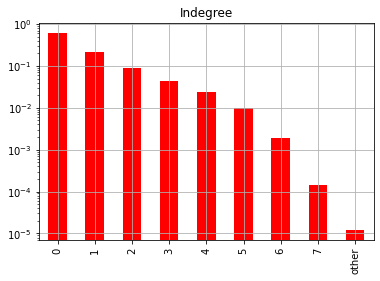

In [208]:
powerLaw(epi_Stats, epi_graph)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 3.629870
Cutoff (xmin)     = 71.000000

Log-likelihood    = -1984.340129

H0: data was drawn from the fitted distribution

KS test statistic = 0.025012
p-value           = 0.953060

H0 could not be rejected at significance level 0.05


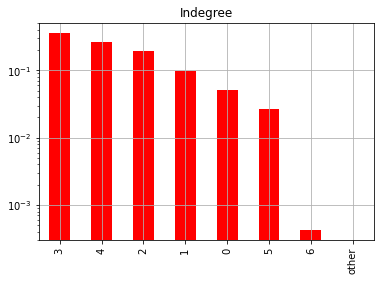

In [209]:
powerLaw(wiki_Stats, wiki_graph)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.270800
Cutoff (xmin)     = 14.000000

Log-likelihood    = -2129.526477

H0: data was drawn from the fitted distribution

KS test statistic = 0.037712
p-value           = 0.459007

H0 could not be rejected at significance level 0.05


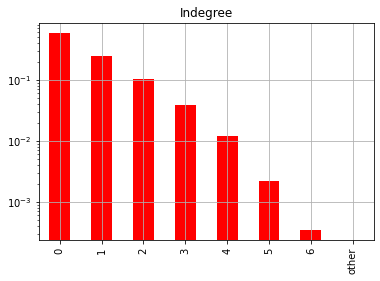

In [210]:
powerLaw(bitcoin_Stats, bitcoin_graph)

In [ ]:
communities(graph)

Size of maximal strongly connected component is 41441
Size of maximal weakly connected component is 119130
29732 37682 10275
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,

In [ ]:
closenessCentrality(graph)

closeness centrality 


https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.richclub.rich_club_coefficient.html#networkx.algorithms.richclub.rich_club_coefficient

In [2]:
# slice dataset into 4 UD graphs

https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edge_subgraph.html#:~:text=Returns%20the%20subgraph%20induced%20by,any%20one%20of%20those%20edges.&text=An%20iterable%20of%20edges%20in%20this%20graph.

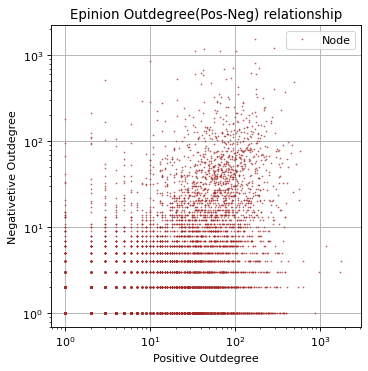

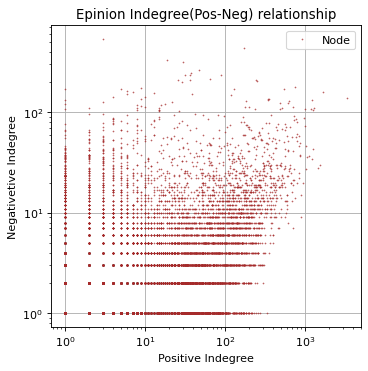

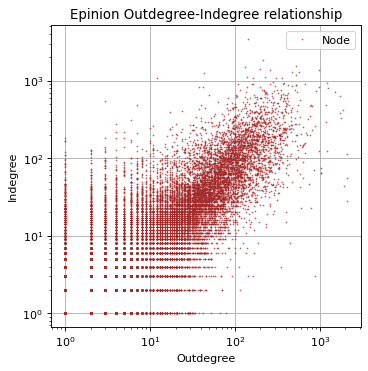

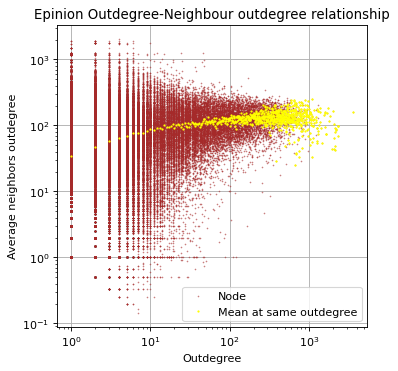

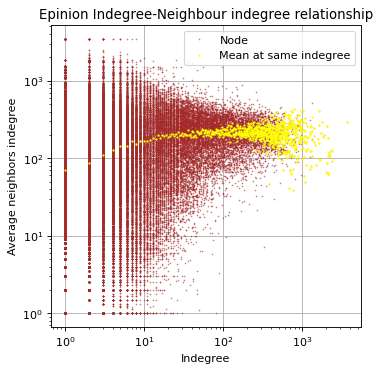

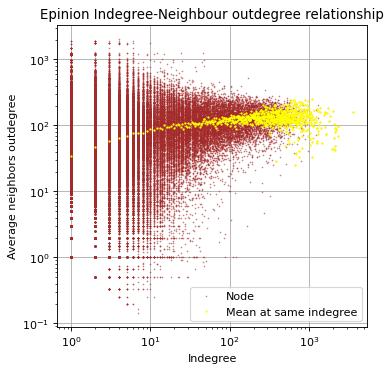

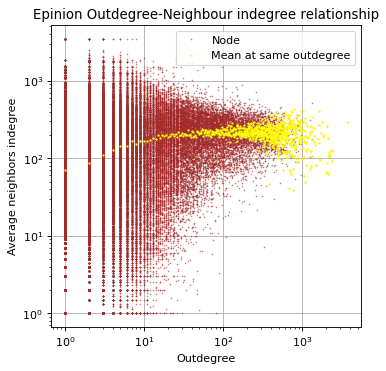

In-In assortativity coefficient = 0.052842835204915777
Out-Out assortativity coefficient = 0.0503775939362448
In-Out assortativity coefficient = 0.07307988435504657
Out-In assortativity coefficient = 0.017546784587849914
Graph assortativity coefficient = 0.017546784587849914


In [63]:
degreeRelationship(epi_Stats,epi_graph,'Epinion')

<ipython-input-48-fda123f10910>:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


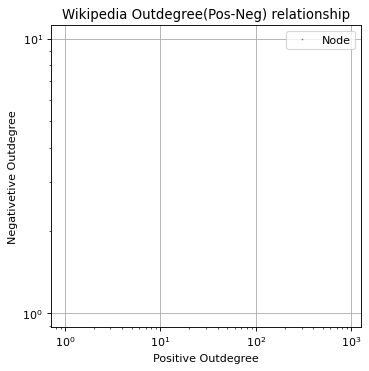

<ipython-input-48-fda123f10910>:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


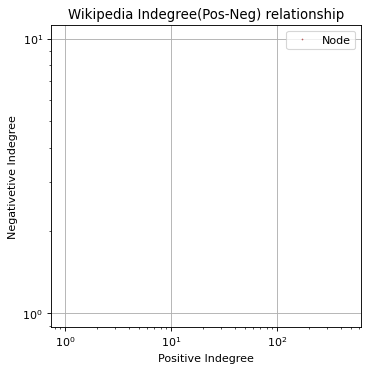

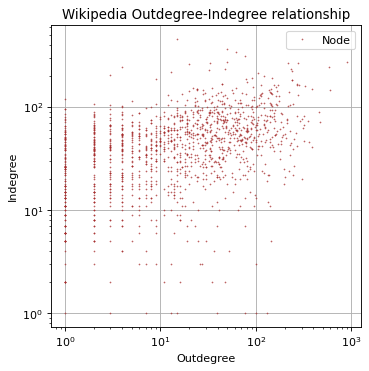

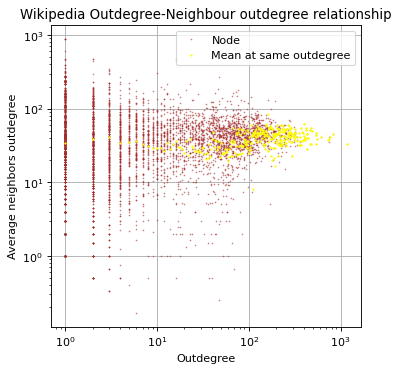

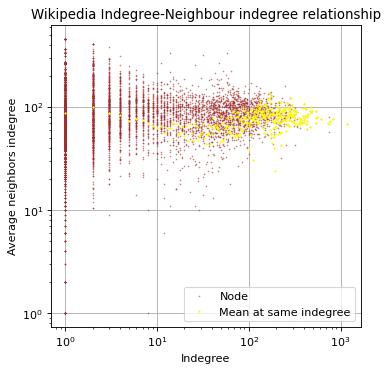

In-In assortativity coefficient = 0.025339639151315253
Out-Out assortativity coefficient = -0.017617003438893494
In-Out assortativity coefficient = -0.005002186113966399
Out-In assortativity coefficient = -0.0710725838860785
Graph assortativity coefficient = -0.0710725838860785


In [50]:
degreeRelationship(wiki_Stats,wiki_graph,'Wikipedia')

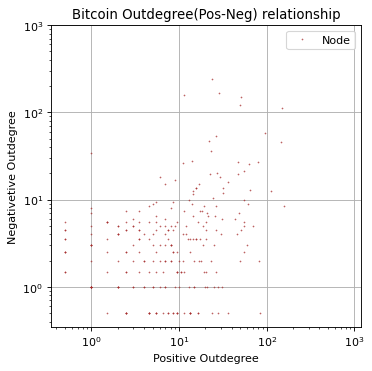

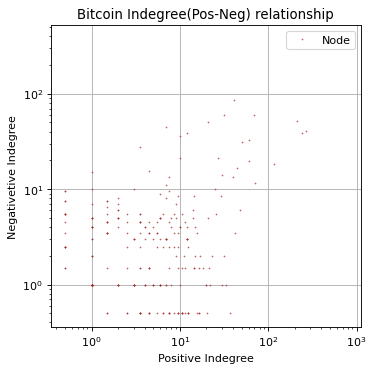

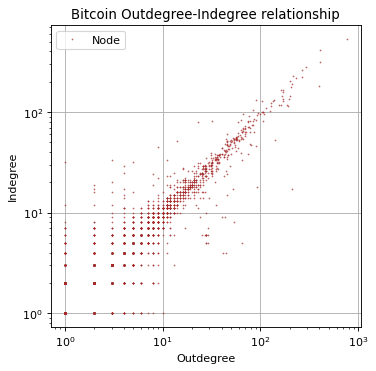

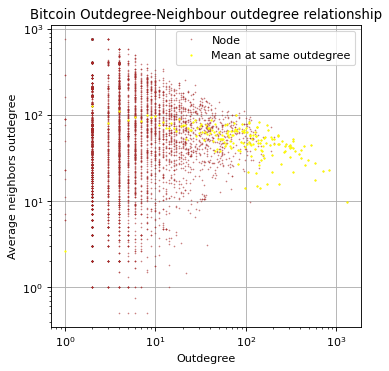

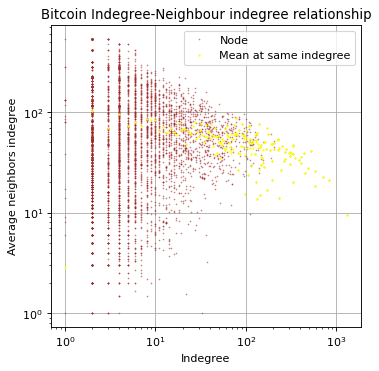

In-In assortativity coefficient = -0.07953460703786223
Out-Out assortativity coefficient = -0.107298413214735
In-Out assortativity coefficient = -0.09200373392822633
Out-In assortativity coefficient = -0.0925342322018264
Graph assortativity coefficient = -0.0925342322018264


In [51]:
degreeRelationship(bitcoin_Stats,bitcoin_graph,'Bitcoin')

In [16]:
print(nx.average_shortest_path_length(epi_weak_graph))

KeyboardInterrupt: 

In [223]:
print(nx.average_shortest_path_length(wiki_weak_graph))

0.7994812433733183


In [79]:
print(nx.average_shortest_path_length(bit_weak_graph))

KeyboardInterrupt: 

In [100]:
ud_epi = epi_weak_graph.to_undirected()
ud_epi.remove_edges_from(nx.selfloop_edges(ud_epi))
rc = nx.rich_club_coefficient(ud_epi, normalized=True, seed=10)
n1,x1,_1 = plt.hist(rc.values(),bins=np.linspace(0, max(rc.values()), 100))
plt.plot(n1)
plt.show()

KeyboardInterrupt: 

In [86]:
nx.write_gml(bitcoin_graph, "bitcoin.gml")

In [51]:
allD = pd.read_csv('allData.csv', delimiter=',')
allD

,indegree,outdegree,eigen,enhanced,closeness,betweenness,Unnamed: 6
0,25,68214,11714,25,NaN,NaN,NaN
1,2292,12168,11824,2292,NaN,NaN,NaN
2,366,112586,11841,366,NaN,NaN,NaN
3,2293,72164,11693,2293,NaN,NaN,NaN
4,433,167,11689,433,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,1891,1605,57518,1345,NaN,NaN,NaN
96,1345,1685,11690,1891,NaN,NaN,NaN
97,2579,4071,11866,2579,NaN,NaN,NaN
98,570,1951,11852,570,NaN,NaN,NaN


In [53]:
interS = np.intersect1d(allD['indegree'],allD['outdegree'])
interS

array([    5,    20,   366,   410,   450,   578,   655,   851,   855,
         966,  1287,  1321,  1352,  1480,  1605,  1652,  1682,  1685,
        4169, 10369, 16973], dtype=int64)

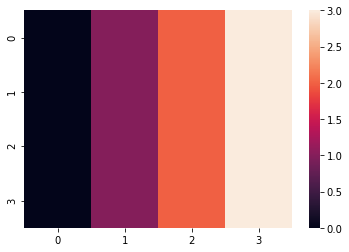

In [55]:
x = [[i for i in range(4)] for j in range(4)]
sns.heatmap(x)
plt.show()

In [15]:
import scipy.sparse
import scipy.sparse.csgraph
A = nx.adjacency_matrix(epi_weak_graph)
B = A.astype(np.bool_)
C = B.toarray().tolil()
D = scipy.sparse.csgraph.floyd_warshall( \
             C, directed=True, unweighted=True)
n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[r] = cc

MemoryError: Unable to allocate 13.2 GiB for an array with shape (119130, 119130) and data type bool